In [8]:
using QuantumOptics
using NBInclude
using Einsum
using LinearAlgebra
# lattice
@nbinclude("Lattice_Basis_Neighbors_Hops.ipynb"; regex=r"#.*executeme")
# mb tools
@nbinclude("QOJulia_utils.ipynb")

proj_MB_Int (generic function with 1 method)

In [166]:
param_dict=Dict{}()

LL = [8,10]
N = LL[1]*LL[2]
vv_lattice = [ [1., 0], [0, 1.] ]
b1 = [0, 0]
vv_basis = [b1]
param_dict["N"] = LL[1]*LL[2]

param_dict["LL"] = LL
param_dict["vv_lattice"] = vv_lattice
param_dict["vv_basis"] = vv_basis

nb=1 # number of basis
t=-1 # hopping amplitude
p=1
q=7
ϕ=p/q # magnetic flux per plaquet
param_dict["gauge"] = "Landau"
param_dict["t"]=t
param_dict["ϕ"]=ϕ
θθ = [0, 0] # initial values for twist angles
param_dict["θθ"]=θθ

sites, site_coord, site_number = get_sites(LL, vv_lattice, vv_basis);
param_dict["sites"] = sites
param_dict["site_coord"] = site_coord
param_dict["site_number"] = site_number

pbc=true # periodic boundary condition
param_dict["pbc"] = pbc
neighbors = [ [1, 0, 1], [-1, 0, 1], [0, 1, 1], [0, -1, 1]  ]
neighbors_list = [ neighbors ]
param_dict["neighbors_list"] = neighbors_list

1-element Vector{Vector{Vector{Int64}}}:
 [[1, 0, 1], [-1, 0, 1], [0, 1, 1], [0, -1, 1]]

In [167]:
function Vpin(site, V0, site_number, LL)
        i_site = site_number[site]
        dimH = LL[1]*LL[2]
        VV   = zeros(dimH,dimH)
        VV[i_site, i_site] = -V0
        return VV
end

Vpin (generic function with 1 method)

In [168]:
function Vimp(sites,VV0,site_number,LL)
    dimH = LL[1]*LL[2]
    VM   = zeros(dimH,dimH)
    for (site, V0) in zip(sites,VV0) 
        VM += Vpin(site, V0, site_number, LL)
    end
    return VM
end

Vimp (generic function with 1 method)

In [169]:
mutable struct impurity
    V0::Float64
    pos::Array{Float64}
    wid::Float64
end

In [170]:
imp1 = impurity(1, [5,5], 2)

impurity(1.0, [5.0, 5.0], 2.0)

In [171]:
imp1.V0

1.0

In [172]:
norm( site_coord[sites[2]] - imp1.pos )

6.4031242374328485

In [173]:
function Vpin2(imp, sites, site_number, site_coord, LL)
        #xc, yc = site_coord[imp_site]
        dimH = LL[1]*LL[2]
        VV   = zeros(dimH,dimH)
        for site in sites
            i_site = site_number[site]
            VV[i_site, i_site] = imp.V0*(tanh( norm( site_coord[site] - imp.pos )/imp.wid )^2-1)
        end
        return VV
end

Vpin2 (generic function with 1 method)

In [174]:
function Vimp2(imps, sites, site_number, site_coord, LL)
    dimH = LL[1]*LL[2]
    VM   = zeros(dimH,dimH)
    for imp in imps 
        VM +=  Vpin2(imp, sites, site_number, site_coord, LL)
    end
    return VM
end

Vimp2 (generic function with 1 method)

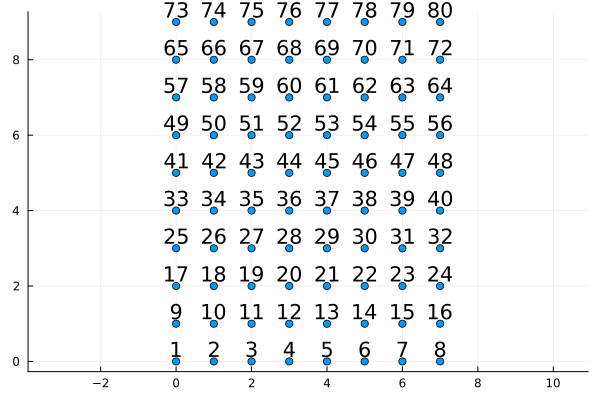

In [175]:
plot_points(sites, site_coord, site_number)

In [176]:
imp_site = sites[5]

3-element Vector{Int64}:
 4
 0
 1

In [177]:
xc, yc = site_coord[ imp_site ]

2-element Vector{Float64}:
 4.0
 0.0

In [178]:
V0 = 5
w = .5
imp1 = impurity(V0, [4.5,4.5], w)
#VimpM = Vpin(imp_site, V0, site_number, LL);
VimpM = Vpin2(imp1, sites, site_number, site_coord, LL);

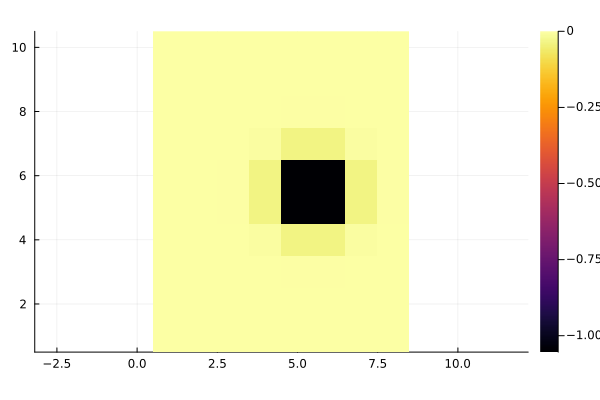

In [179]:
heatmap(reshape(diag(VimpM),LL[1],LL[2])', aspect_ratio=1)

In [180]:
imp_sites = [ sites[8], sites[2] ]
imp1 = impurity(5, [1,1], .5)
imp2 = impurity(10, [1,3], .5)
imps = [imp1, imp2]

2-element Vector{impurity}:
 impurity(5.0, [1.0, 1.0], 0.5)
 impurity(10.0, [1.0, 3.0], 0.5)

In [181]:
#VimpM = Vimp(imp_sites, VV0, site_number, LL);
VimpM = Vimp2(imps, sites, site_number, site_coord, LL);

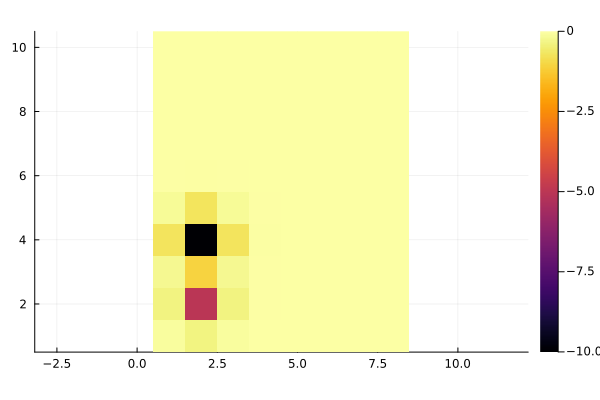

In [182]:
heatmap(reshape(diag(VimpM),LL[1],LL[2])', aspect_ratio=1)

In [183]:
basis = NLevelBasis(N) 
param_dict["basis"] = basis;

param_dict["model_H1"] = get_Hofstadter_hamiltonian

H_T = get_Hofstadter_hamiltonian(param_dict)
H_Kin = get_sp_op(basis, H_T)
Vimp_op = get_sp_op(basis, VimpM);

In [184]:
function Himp(imps, H_Kin)
    VimpM = Vimp2(imps, sites, site_number, site_coord, LL);
    Vimp_op = get_sp_op(basis, VimpM)
    return H_Kin + Vimp_op
end

Himp (generic function with 1 method)

In [185]:
EE_Kin, UU_Kin = eigen(dense(H_Kin).data);

imps = [ impurity(2, [2,7], .5), 
         impurity(2.0001, [5,2], .5)]

H1 = Himp(imps, H_Kin)
EE, UU = eigen(dense(H1).data);
EE, UUS = eigenstates(dense(H1));

imps = [ impurity(1, [2,7], .5), 
         impurity(0, [5,2], .5)]
H1 = Himp(imps, H_Kin)
EE2, UU2 = eigen(dense(H1).data);
EE2, UUS2 = eigenstates(dense(H1));

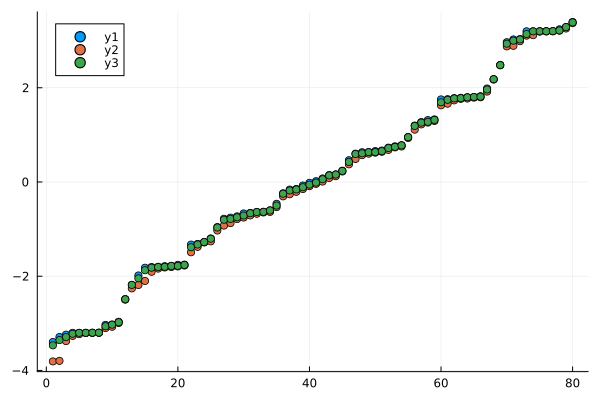

In [186]:
scatter(EE_Kin)
scatter!(EE)
scatter!(EE2)
#ylims!(-4,-3)

In [189]:
x0, y0 = site_coord[ sites[20] ]
x1, y1 = site_coord[ sites[22] ]
x2, y2 = site_coord[ sites[54] ]
x3, y3 = site_coord[ sites[52] ]

2-element Vector{Float64}:
 3.0
 6.0

In [190]:
imps = [ impurity(2, [x0,y0], .5)]
H1 = Himp(imps, H_Kin)
EE, UUS_0 = eigenstates(dense(H1))
U_first = copy(UUS[1]);

In [212]:
widd = 1
V00 = 1
A = 1
U_imp = []
step=0.1
for x_t in x0:step:x1
    imps = [ impurity(V00, [x_t,y0], widd)]
    H1 = Himp(imps, H_Kin)
    EE, UU = eigen(dense(H1).data)
    EE, UUS = eigenstates(dense(H1))
    push!(U_imp,UUS)
    A *= (UUS_0[1]'*UUS[1]) / abs(UUS_0[1]'*UUS[1])
    UUS_0 = copy(UUS)
end
for y_t in y1:step:y2
    imps = [ impurity(V00, [x1,y_t], widd)]
    H1 = Himp(imps, H_Kin)
    EE, UU = eigen(dense(H1).data)
    EE, UUS = eigenstates(dense(H1))
    push!(U_imp,UUS)
    A *= (UUS_0[1]'*UUS[1]) / abs(UUS_0[1]'*UUS[1])
    UUS_0 = copy(UUS)
end
for x_t in x2:-step:x3
    imps = [ impurity(V00, [x_t,y2], widd)]
    H1 = Himp(imps, H_Kin)
    EE, UU = eigen(dense(H1).data)
    EE, UUS = eigenstates(dense(H1))
    push!(U_imp,UUS)
    A *= (UUS_0[1]'*UUS[1]) / abs(UUS_0[1]'*UUS[1])
    UUS_0 = copy(UUS)
end
for y_t in y3:-step:y0
    imps = [ impurity(V00, [x3,y_t], widd)]
    H1 = Himp(imps, H_Kin)
    EE, UU = eigen(dense(H1).data)
    EE, UUS = eigenstates(dense(H1))
    push!(U_imp,UUS)
    A *= (UUS_0[1]'*UUS[1]) / abs(UUS_0[1]'*UUS[1])
    UUS_0 = copy(UUS)
end

In [213]:
angle(A)/pi

0.3952175627535325

In [214]:
16/7-angle(A)/pi

1.8904967229607532

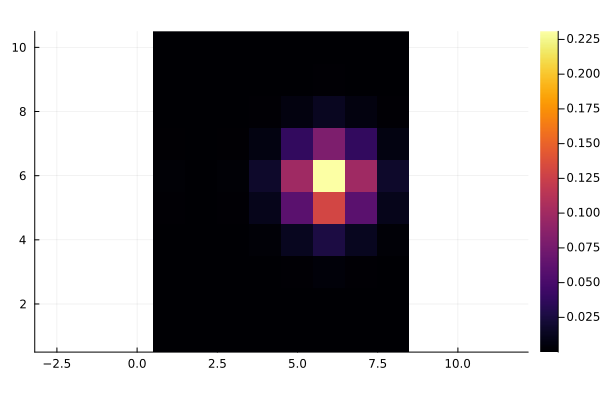

In [215]:
heatmap(reshape(real( diag( dm(U_imp[50][1]).data ) ),LL[1],LL[2])', aspect_ratio=1)

In [23]:
EE[1:3]

3-element Vector{Float64}:
 -3.8946415236453045
 -3.894601452924709
 -3.4382825112818725

In [24]:
function calc_pr(state)
    return sum( ( real( diag( dm(state).data ) ) ).^2 )
end

calc_pr (generic function with 1 method)

In [25]:
prs=[]
prs2=[]
for i in 1:prod(LL)
    pr = calc_pr(UUS[i])
    push!(prs,pr)
    pr = calc_pr(UUS2[i])
    push!(prs2,pr)
end

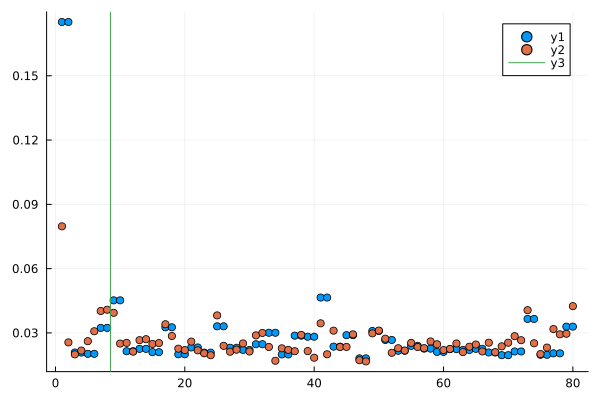

In [26]:
scatter(prs)
scatter!(prs2)
vline!([8.5])

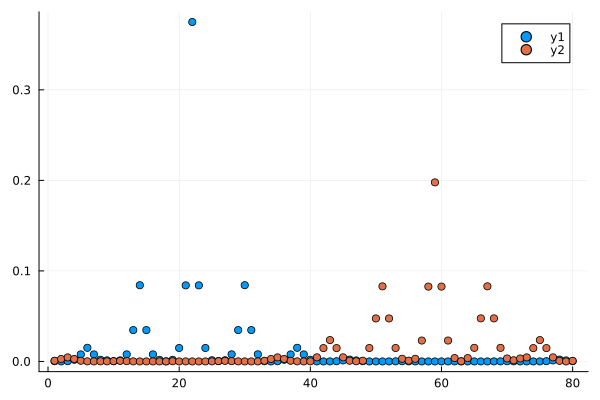

In [27]:
scatter(  real( diag( dm(UUS[1]).data ) ) )
scatter!(  real( diag( dm(UUS2[1]).data ) ) )

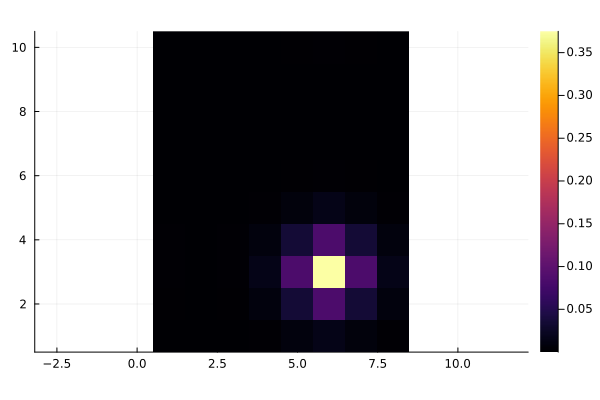

In [28]:
heatmap(reshape(real( diag( dm(UUS[1]).data ) ),LL[1],LL[2])', aspect_ratio=1)

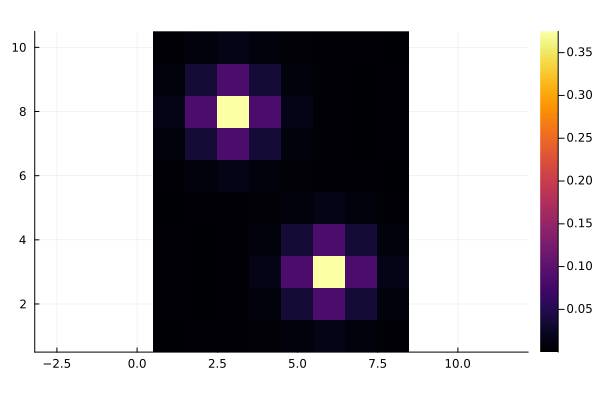

In [29]:
heatmap(reshape(real( diag( dm(UUS[1]).data+dm(UUS[2]).data ) ),LL[1],LL[2])', aspect_ratio=1)

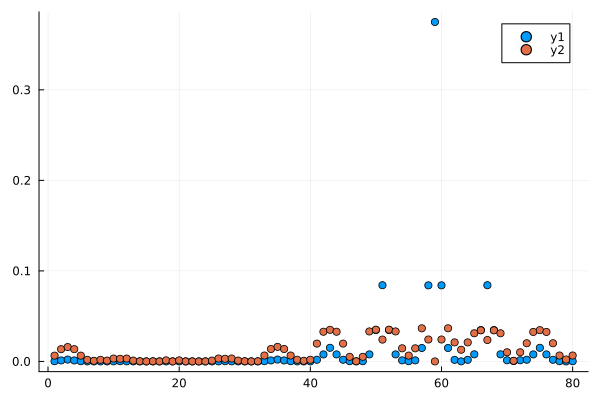

In [30]:
scatter(  real( diag( dm(UUS[2]).data ) ) )
scatter!(  real( diag( dm(UUS2[2]).data ) ) )

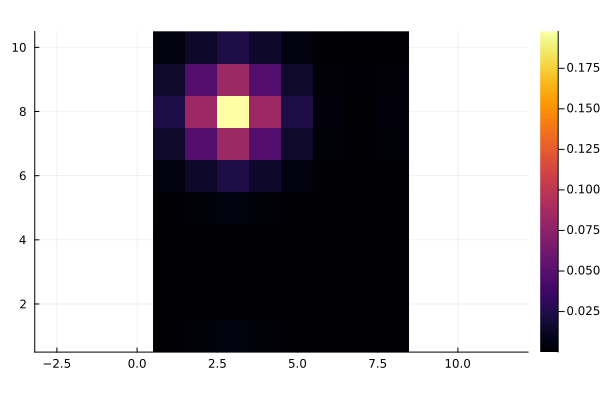

In [31]:
heatmap(reshape(real( diag( dm(UUS2[1]).data ) ),LL[1],LL[2])', aspect_ratio=1)

# Path

In [34]:
function circular_path(θ,center,radius)
    return [center[1]+radius*cos(θ), center[2]+radius*sin(θ)]
end

circular_path (generic function with 1 method)

In [35]:
center = [4,4]
radius = 3 
θ = pi/4

imp_pos = circular_path(θ,center,radius)
imp_pos2 = circular_path(θ+pi,center,radius)

V0 = 1
w0 = 1

imps = [ impurity(1.1*V0, imp_pos2, w0), 
         impurity(V0, imp_pos, w0) ]

H1 = Himp(imps, H_Kin)
EE, UU = eigen(dense(H1).data);
EE, UUS = eigenstates(dense(H1));

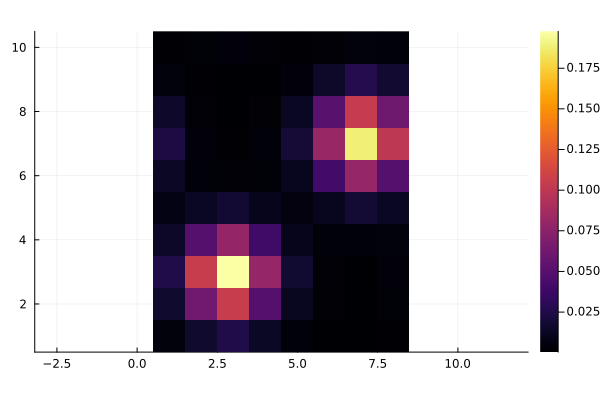

In [36]:
heatmap(reshape(real( diag( dm(UUS[1]).data+dm(UUS[2]).data ) ),LL[1],LL[2])', aspect_ratio=1)

# 2 Body Interaction

In [35]:
?SparseOperator

search: SparseOperator SparseSuperOperator



```
SparseOperator(b1[, b2, data])
```

Sparse array implementation of Operator.

The matrix is stored as the julia built-in type `SparseMatrixCSC` in the `data` field.


In [36]:
U = 2;

In [37]:
V2 = SparseOperator(basis⊗basis)
for m in 1:N
    V2 += U/2 * transition(basis,m,m)⊗transition(basis,m,m)
end

# Projection

In [40]:
substates = 1:3
PN = 3
basis_tilde = SubspaceBasis(basis, UUS[substates])
basis_tilde2 = basis_tilde⊗basis_tilde
states_mb_tilde = bosonstates(basis_tilde, PN)
basis_mb_tilde  = ManyBodyBasis(basis_tilde, states_mb_tilde)

ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=80), states:3), states:10)

In [41]:
P1 = projector(basis, basis_tilde)
P1_dag = dagger(P1)
P1M = P1.data
P1_dagM = P1_dag.data
P2M = (P1⊗P1).data
P2_dagM = (P1_dag⊗P1_dag).data;
H1M = H1.data;
V2M = V2.data;

In [42]:
size(H1M),size(V2M)
V2.data

6400×6400 SparseArrays.SparseMatrixCSC{ComplexF64, Int64} with 80 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⎦

In [46]:
H1_tildeM = P1_dagM * H1M * P1M
V2_tildeM =  P2_dagM * V2M * P2M;

In [47]:
H1_tilde = Operator(basis_tilde, H1_tildeM);

V2_tilde = Operator(basis_tilde2, V2_tildeM);

H_NI_tilde_mb = manybodyoperator(basis_mb_tilde, H1_tilde);

Vint_tilde_mb = manybodyoperator(basis_mb_tilde, V2_tilde);

H_tilde_mb = H_NI_tilde_mb + Vint_tilde_mb;

H_tilde_mb = (H_tilde_mb + H_tilde_mb')/2;

In [51]:
E_tilde_mb, U_tilde_mb = eigenstates(H_tilde_mb);

In [52]:
heatmap(reshape(real( diag( dm(U_tilde_mb[1]).data) ),LL[1],LL[2])', aspect_ratio=1)

LoadError: DimensionMismatch: new dimensions (8, 10) must be consistent with array size 10

In [52]:
println( EE[1:3] )
println( EE_sub[1:3] )

[-3.7980128067769985, -3.7543613772972297, -3.5368582417214625]
[-3.732008470224108, -3.698537315687506, -3.5248932482151027]


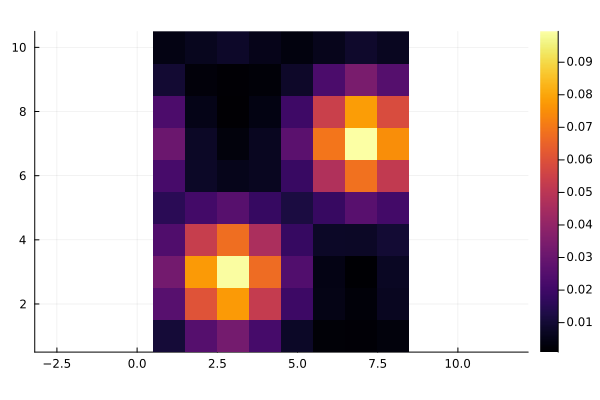

In [53]:
heatmap(reshape(real( diag( dm(Pt*UUS_sub[1]).data+dm(Pt*UUS_sub[2]).data ) ),8,10)', aspect_ratio=1)

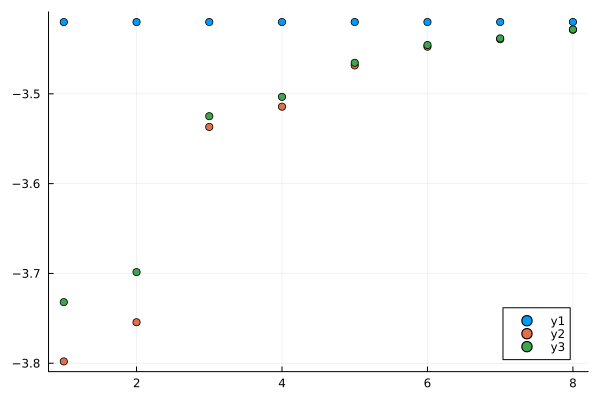

In [54]:
scatter(EE_Kin[1:LL[1]])
scatter!(EE[1:LL[1]])
scatter!(EE_sub)

In [55]:
param_dict["projection"] = subspace_proj, P, Pt;

In [56]:
param_dict["PN"] = [3]
basis_mb = get_basis_mb(param_dict)
param_dict["dimH_mb"] = length(basis_mb)

120

In [57]:
H1_NI_mb = get_mb_op(basis_mb, H1_proj);

In [58]:
EE_mb, UU_mb = eigen(dense(H1_NI_mb).data);
EE_mb[1:5]

5-element Vector{Float64}:
 -11.19602541067233
 -11.162554256135728
 -11.129083101599125
 -11.095611947062524
 -10.988910188663318